<a href="https://colab.research.google.com/github/kevinrchilders/lego-figures/blob/master/lego_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lego figure classifier

The data set contains pictures of lego figures, and the goal is to build a classifier.
The data set is very small.

---

## Setting up and loading the data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as zipref:
  zipref.extractall('/lego')

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
import pandas
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

In [5]:
data = np.array(pandas.read_csv('/lego/index.csv'))

In [6]:
X_train = []
X_val = []
Y_train = []
Y_val = []

for _, path, y, t_or_v in data:
  if t_or_v == 'train':
    X_train.append(image.img_to_array(image.load_img('/lego/'+path, target_size=(224,224))))
    Y_train.append(y)
  else:
    X_val.append(image.img_to_array(image.load_img('/lego/'+path, target_size=(224,224))))
    Y_val.append(y)

X_train = np.array(X_train)/255
X_val = np.array(X_val)/255
Y_train = to_categorical(np.array(Y_train)-1)
Y_val = to_categorical(np.array(Y_val)-1)


---

## Playing with the data

(182, 224, 224, 3)
(170, 224, 224, 3)
(182, 31)
(170, 31)


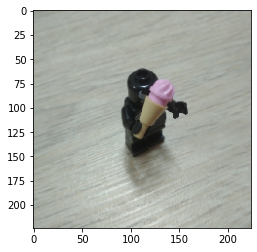

In [10]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

TEST_IMAGE = 9

plt.imshow(X_train[TEST_IMAGE])
# print(X_train[TEST_IMAGE])
# print(Y_train[TEST_IMAGE])

---

## Building a model from scratch

In [ ]:
# Hyperparameters and callbacks

learning_rate = 0.01
batch_size = 8
epochs = 250
# dropout_rate = 0.8

def scheduler(epoch):
  return learning_rate - learning_rate * 9 * epoch /epochs / 10

learning_rate_callback = LearningRateScheduler(scheduler)

save_callback = ModelCheckpoint('/lego/best.hdf5', save_best_only=True)

early_stopping_callback = EarlyStopping(patience=10)

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

model = Sequential([
  Conv2D(16, (5,5), (2,2), input_shape=(512, 512, 3)),
  BatchNormalization(),
  ReLU(),
  MaxPooling2D(2,2),
  # Dropout(dropout_rate),
  Conv2D(32, (5,5), (2,2)),
  BatchNormalization(),
  ReLU(),
  MaxPooling2D(2,2),
  # Dropout(dropout_rate),
  Conv2D(64, (3,3)),
  BatchNormalization(),
  ReLU(),
  MaxPooling2D(2,2),
  # Dropout(dropout_rate),
  Flatten(),
  Dense(64),
  BatchNormalization(),
  ReLU(),
  Dense(48),
  BatchNormalization(),
  ReLU(),
  # Dropout(dropout_rate),
  Dense(31, activation='softmax')
])

# model.summary()

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(data_gen.flow(X_train, Y_train, batch_size=batch_size), 
                    steps_per_epoch = len(X_train) / batch_size, 
                    epochs = epochs, 
                    callbacks = [
                                 learning_rate_callback,
                                 save_callback,
                                 early_stopping_callback
                                 ],
                    validation_data = (X_val, Y_val)
                    )

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs[10:], loss[10:], 'g', label='Training loss')
# plt.plot(epochs[10:], val_loss[10:], 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.figure()


# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])


plt.show()

In [ ]:
tf.keras.backend.clear_session()

So far, the best I've got on the validation set is $\approx 60$% accuraccy.

---

## Using transfer learning

I'm going to import the InceptionResNetV2 as trained on the ImageNet dataset and add a couple of dense layers to the top.

In [41]:
# base_model = tf.keras.applications.InceptionResNetV2(include_top = False, input_shape=(512, 512, 3))
base_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False

In [90]:
# Hyperparameters and callbacks

learning_rate = 0.0001
decay_rate = 0.5
batch_size = 91
epochs = 100
dropout_rate = 0.8
l2_penalty = 0.07
num_hidden = 256

def scheduler(epoch):
  return learning_rate / (1 + decay_rate * epoch)
  # return learning_rate
learning_rate_callback = LearningRateScheduler(scheduler)

save_callback = ModelCheckpoint('/lego/best.hdf5', save_best_only=True)

early_stopping_callback = EarlyStopping(patience=3)

data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [43]:
# Create model with layers locked

inputs = base_model.inputs
x = base_model.layers[-1].output
x = Flatten()(x)
# x = Dense(num_hidden, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(31, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_penalty))(x)

model2 = Model(inputs, outputs)

# model2.summary()

optimizer = Adam(learning_rate=learning_rate)

model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [91]:
# Unlock some layers

# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# for layer in model2.layers[:135]:
#    layer.trainable = False
# for layer in model2.layers[135:]:
#    layer.trainable = True

for layer in model2.layers:
   layer.trainable = True

optimizer = Adam(learning_rate=learning_rate)

model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [92]:
history = model2.fit(data_gen.flow(X_train, Y_train, batch_size=batch_size), 
                    steps_per_epoch = len(X_train) / batch_size, 
                    epochs = epochs, 
                    callbacks = [
                                 learning_rate_callback,
                                 save_callback,
                                 early_stopping_callback
                                 ],
                    validation_data = (X_val, Y_val)
                    )

Epoch 1/100
2/2 [==============================] - 2s 985ms/step - loss: 0.2025 - accuracy: 1.0000 - val_loss: 0.3668 - val_accuracy: 0.9529
Epoch 2/100
2/2 [==============================] - 1s 667ms/step - loss: 0.1909 - accuracy: 1.0000 - val_loss: 0.3635 - val_accuracy: 0.9647
Epoch 3/100
2/2 [==============================] - 1s 652ms/step - loss: 0.1822 - accuracy: 1.0000 - val_loss: 0.3618 - val_accuracy: 0.9588
Epoch 4/100
2/2 [==============================] - 1s 654ms/step - loss: 0.1882 - accuracy: 1.0000 - val_loss: 0.3577 - val_accuracy: 0.9588
Epoch 5/100
2/2 [==============================] - 1s 685ms/step - loss: 0.1770 - accuracy: 1.0000 - val_loss: 0.3541 - val_accuracy: 0.9529
Epoch 6/100
2/2 [==============================] - 1s 660ms/step - loss: 0.1694 - accuracy: 1.0000 - val_loss: 0.3514 - val_accuracy: 0.9647
Epoch 7/100
2/2 [==============================] - 1s 677ms/step - loss: 0.1779 - accuracy: 1.0000 - val_loss: 0.3487 - val_accuracy: 0.9647
Epoch 8/100
2

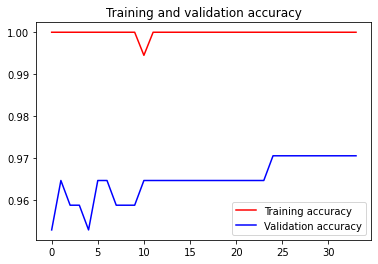

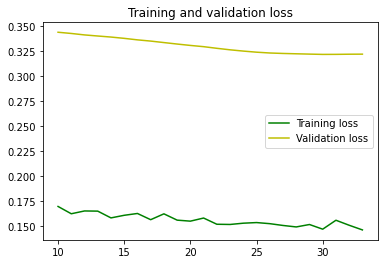

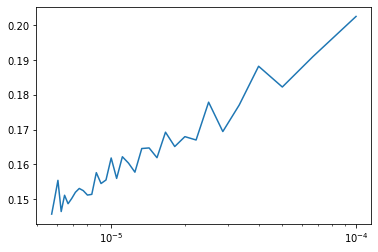

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs[10:], loss[10:], 'g', label='Training loss')
plt.plot(epochs[10:], val_loss[10:], 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])


plt.show()

---

## Error Analysis

After some hyperparamater tweaking and training, the model I found is the following.

In [11]:
final_model = tf.keras.models.load_model('mobile_net_model.hdf5')

In [42]:
Y_train_predict = np.argmax(final_model.predict(X_train),axis=1)+1
Y_val_predict = np.argmax(final_model.predict(X_val),axis=1)+1

# Y_train = np.argmax(Y_train,axis=1)+1
# Y_val = np.argmax(Y_val,axis=1)+1

print('Training accuracy:' + str(np.sum(Y_train_predict == Y_train)/len(Y_train)))
print('Validation accuracy:' + str(np.sum(Y_val_predict == Y_val)/len(Y_val)))

Training accuracy:1.0
Validation accuracy:0.9352941176470588


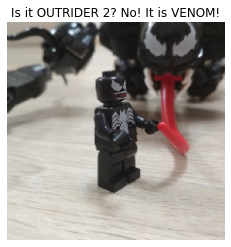

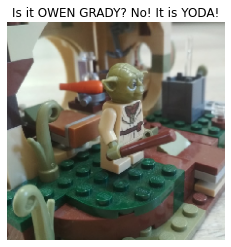

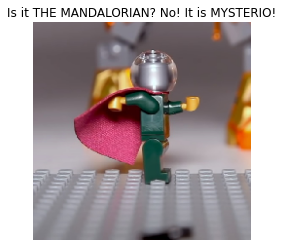

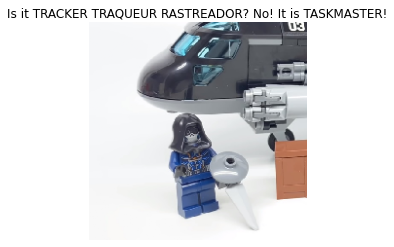

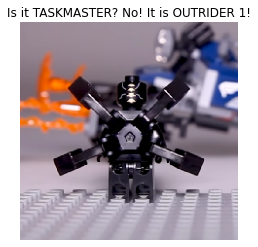

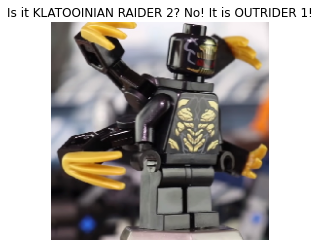

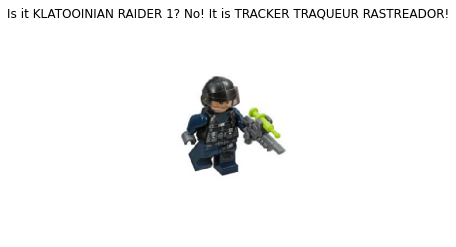

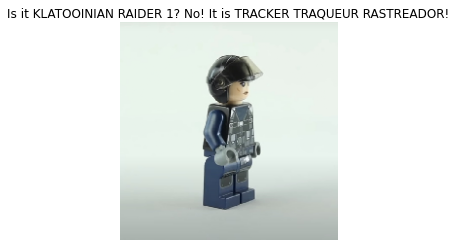

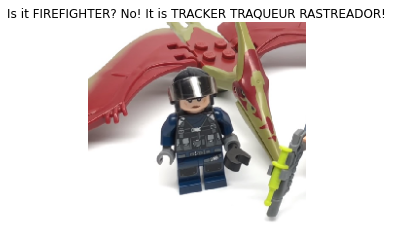

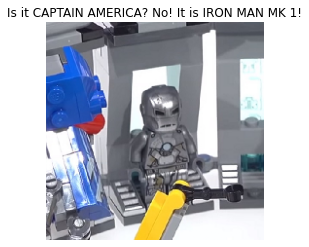

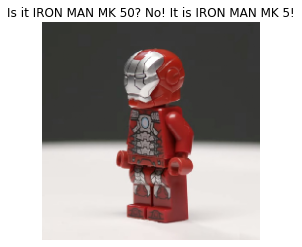

<Figure size 432x288 with 0 Axes>

In [52]:
mdata = np.array(pandas.read_csv('/lego/metadata.csv'))

name_dict = {}

for _, i, _, _, name in mdata:
  name_dict[i] = name

for i in range(len(Y_val)):
  if (Y_val[i] != Y_val_predict[i]).all():
    # print('Is it ' + name_dict[Y_val_predict[i]] + '? No! It is ' + name_dict[Y_val[i]] + '!')
    plt.imshow(X_val[i])
    plt.title('Is it ' + name_dict[Y_val_predict[i]] + '? No! It is ' + name_dict[Y_val[i]] + '!')
    plt.axis('off')
    plt.figure()